# <a name="head">CSI5139</a>
* * *
# Assignment 1 | Image Labelling - Linear Classification
* * * 
## In this jupyter notebook, I will be dicussing the following
***
- ### [1.1 Getting Started](#1_1)
    - #### [1.1.1 Fetching and preprocessing the dataset from the folders in an automatic way](#1_1_1)
    - #### [1.1.2 Collect data as inputs (X) and groundtruth (y)](#1_1_2)
    - #### [1.1.3 Splitting the data into train/dev/test sets](#1_1_3)
- ### [1.2 Binary Classifier](#1_2)
    - #### [1.2.1 Model selection and training](#1_2_1)
    - #### [1.2.2 Measuring perfomance metrics (accuracy, percision, recall, and confusion matrix)](#1_2_2)
    - #### [1.2.3 Plotting ROC curve](#1_2_3)
- ### [1.3 Multiclass Classifier](#1_3)
    - #### [1.3.1 Preparing the classification data](#1_3_1)
    - #### [1.3.2 Model selection and training](#1_3_2)
    - #### [1.3.3 Measuring perfomance metrics (accuracy and confusion matrix)](#1_3_3)
- ### [1.4 Improved Classification of Colour Image (Bonus) | Huge increase in performance (100%)](#1_4)
    - #### [1.4.1 Testing the model from **1.3** with external images](#1_4_1)
    - #### [1.4.2 Preparing the classification color data](#1_4_2)
    - #### [1.4.3 Feature selection and extraction](#1_4_3)
    - #### [1.4.4 Model selection and training](#1_4_4)
    - #### [1.4.5 Measuring perfomance metrics (accuracy and confusion matrix)](#1_4_5)
- ### [Conclusion](#conc)

### Installing (if not already installed) and importing all the packages that are going to be used thoughout the assignment. 

In [1]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install scikit-image

In [2]:
%autosave 60
%matplotlib inline
import os
import skimage
from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt
import ntpath
import numpy as np

Autosaving every 60 seconds


## <a name="1_1">1.1 Getting Started</a>
***
- #### [1.1.1 Fetching and preprocessing the dataset from the folders in an automatic way](#1_1_1)
- #### [1.1.2 Collecting data as inputs (X) and groundtruth (y)](#1_1_2)
- #### [1.1.3 Splitting the data into train/dev/test sets](#1_1_3)

### <a name="1_1_1">1.1.1 Fetching the dataset from the folders in an automatic way</a>
***
Since I want my implementation to be as generic and reusable as possible, I have designed and implemented some helper functions that will be used to fetch and prepare the images from the dataset's folders.

By doing that, I will have ONE a high-level API function that is responsible for gathering and preparing the images within a dataset directories (not just for this dataset, it can also work with any other dataset with the same structure), that is given only the dataset directory name, and some options to follow (image color channel, rescaling factor, etc.).

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [3]:
def get_subdirectories(dir_name):
    '''
        This functions returns a list of all subdirectories' paths under a specific directory name.
        
        params:
            dir_name: str
        returns:
            subdirectories_list: List[str]
    '''
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, subdir_name) for subdir_name in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, subdir_name))]
    else:
        return []
    
def get_files_within_dir(dir_name, ext):
    '''
        This function returns all the files' paths withing a specific directory with the same extension as [ext]
        
        params:
            dir_name: str
            ext: str
        returns:
            all_files_found_list: List[str]
    '''
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, file_name) for file_name in os.listdir(dir_name) if file_name.endswith(ext)]
    else:
        return []
    
def read_images_from_files(filenames, rescale_factor, rgb=True, flatten=False):
    '''
        This function takes a list of images' filenames, reads all the images, and return them based on some parameters given,
        to the function as the rescaling factor, either RGB or grayscale, and either the image will be flattened or not
        
        params: 
            filenames: List[str]
            rescale_factor: float
            rgb: bool (optional) default=True
            flatten: bool (optional) default=False
        return:
            List[Tuple[np.ndarray, Tuple[int, int], str]] -> List[(image, original_size, filename)]
    '''
    def read_image_from_file(filename):
        '''
            This function takes an image's filename, read the image pixels in either RGB or grayscale format as specified,
            resizes the image with the given rescaling factor, flattens the image so it can be one vector on numbers,
            and returns the preprocessed image and its original shape
            
            params: 
                filename: str
            returns:
                img: np.ndarray
                org_size: Tuple[int, int]
        '''
        img = skimage.io.imread(filename, as_gray=(not rgb))
        org_size = img.shape
        img = rescale(img, rescale_factor, anti_aliasing=True)
        
        if (flatten==True):
            img = img.flatten()
        return img, org_size
        
    images = []
    for filename in filenames:
        img, org_size = read_image_from_file(filename)
        images.append((img, org_size, filename))
    return images

def get_all_images(dataset_dirname, rescale_factor, RGB=True, flatten=False):
    '''
        This function acts as the main API function, and is responsible for fetching and preprocessing all the images
        within the dataset directory, it uses the already defined helper functions
        
        params:
            dataset_dirname: str
            rescale_factor: float
            RGB: bool
            flatten: bool
        return:
            all_images: List[Tuple[np.ndarray, Tuple[int, int], str]] -> List[(image, original_size, filename)]
    '''
    subdirectories = get_subdirectories(dataset_dirname)
    all_images = []
    for subdir in subdirectories:
        images_filenames = get_files_within_dir(subdir, '.png')
        subdir_images = read_images_from_files(filenames=images_filenames, rescale_factor=rescale_factor, rgb=RGB, flatten=flatten)
        all_images += subdir_images
    return all_images

def get_images_by_keywords(all_images, keywords):
    '''
        This function takes all the images, and some keywords, and returns a subset of all the images based on whether or not
        the keywords were found in their filenames
        
        params: 
            all_images: List[Tuple[np.ndarray, Tuple[int, int], str]] -> List[(image, original_size, filename)]
            keywords: List[str]
        return:
            images: List[np.ndarray]
            original_sizes: List[Tuple[int, int]] -> each image's original shape
    '''
    def keywords_found(filename):
        '''
            This function takes a file name, and checks whether or not the keywords are found in the filename
            
            params:
                filename: str
            return:
                found: bool
        '''
        found = True
        image_filename = ntpath.basename(filename)
        for keyword in keywords:
            found = (found and (keyword in image_filename))
        return found
    
    images = [image[0] for image in all_images if keywords_found(image[2]) == True]
    org_sizes = [image[1] for image in all_images if keywords_found(image[2]) == True]
    return images, org_sizes

Now I need to collect the data for the **first task**, so all I need to do is to call the helper method that we already have implemented.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [6]:
'''
    Defining the global variables that I will be using to extract and pre-process the image data
        - Dataset directory name
        - Rescaling factor as mentioned in the assignment PDF (1/5)
        - The corresponding keywords for each of the classes of the images based on their illuminations
'''
DATASET_DIRNAME = "Phos2_0_2MP"
RESCALING_FACTOR = 1. / 5.
#############################################################################
NONUNI_KEYWORDS = ["_nonuni_"]      # For the 1st task | Class 0
UNI_KEYWORDS = ["_uni_"]            # For the 1st task | Class 1
#############################################################################
OVEREXPOSED_KEYWORDS = ["_plus_"]   # For the 2nd and 3rd task | Class 0
UNDEREXPOSED_KEYWORDS = ["_minus_"] # For the 2nd and 3rd task | Class 1
REGULAR_KEYWORDS = ["_uni_", "_0"]  # For the 2nd and 3rd task | Class 2
NONUNI_KEYWORDS = ["_nonuni_"]      # For the 2nd and 3rd task | Class 2

### <a name="1_1_2">1.1.2 Collecting data as inputs (X) and groundtruth (y)</a>
***
Now I just need to call the function **get_all_images** to get a list of all images ready for the **Task 1** and **Task 2**, as the data needed is grayscale.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [7]:
grayscale_data = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=False, flatten=True)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [8]:
def generate_labels_list(list_len, label):
    '''
        This function takes a list length and a specific label and generates a numpy array with that specific length
        and have all the elements values set to that specific label
        
        params:
            list_len: int
            label: int
        return:
            generated_labels: List[int]
    '''
    return np.full(list_len, label).tolist()

Now I just need to fetch the data for each class to be used in **Task 1**, so I will use only the **non-uniform** illumination and the **uniform** illumination images as my 2 classes of interest, as well as defining labels for each class, so I will choose **label 0** for the **non-uniform** illumination images and **label 1** for the **uniform** illumination images.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [9]:
# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
nonuni_images, nonuni_org_sizes = get_images_by_keywords(grayscale_data, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 0)

# fetching uniform illumination images by searching for the "uni" keyword in the images' filenames 
uni_images, uni_org_sizes = get_images_by_keywords(grayscale_data, UNI_KEYWORDS)
uni_labels = generate_labels_list(len(uni_images), 1)

# defining length of each class of images
nonuni_len = len(nonuni_images)
uni_len = len(uni_images)
print("Number of examples on non-uniform illumination pictures is: " + str(nonuni_len) + " with label " + str(nonuni_labels[0]))
print("Number of examples on uniform illumination pictures is: " + str(uni_len) + " with label " + str(uni_labels[0]))

Number of examples on non-uniform illumination pictures is: 90 with label 0
Number of examples on uniform illumination pictures is: 135 with label 1


Let's just define a function that plots an image to make sure we are fetching the data in the right way by plotting a random examples for the images in either class 0 or 1.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

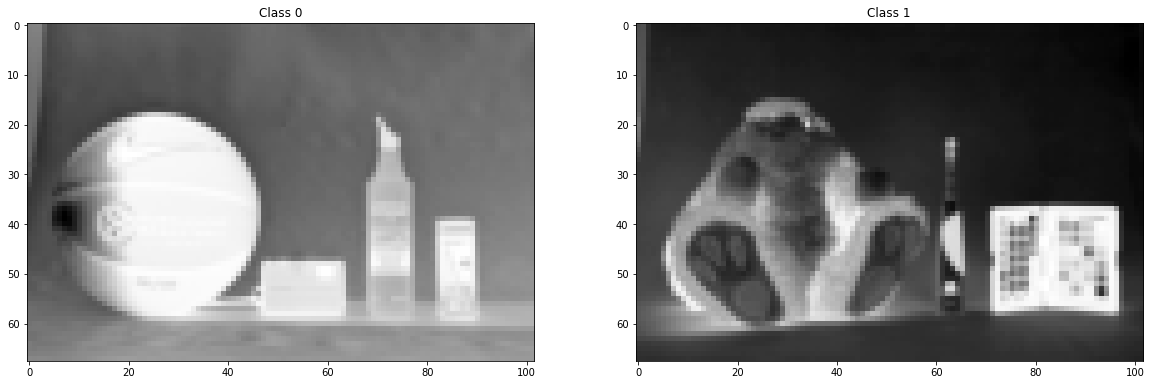

In [10]:
def plot_image(image, title=None):
    plt.title(title)
    plt.imshow(image,
               cmap = matplotlib.cm.binary,
               interpolation="nearest")

def plot_random_image(image_list, label_list, org_size_list):
    ''' 
        plotting a random image from the images with non-uniform illumination
        first we generate a random index bounded by the non-uniform illumination images data length
        then we get that image's original size
        then we rescale that size using the golbally defined RESCALING FACTOR
        then we reshape the random image using that rescaled shape
        finally we plot the image
    '''
    if (len(image_list) == len(label_list) and len(label_list) == len(org_size_list)):
        rand_idx = np.random.randint(low=0, high=len(image_list)-1)
        org_size = org_size_list[rand_idx]
        rescaled_shape = (int(org_size[0] * RESCALING_FACTOR), int(org_size[1] * RESCALING_FACTOR))
        plot_image(image_list[rand_idx].reshape(rescaled_shape), "Class " + str(label_list[rand_idx]))
    else:
        return None

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plot_random_image(nonuni_images, nonuni_labels, nonuni_org_sizes)
fig.add_subplot(1, 2, 2)
plot_random_image(uni_images, uni_labels, uni_org_sizes)

Now we just construct the data **X** and groundtruth **y** by just stacking the fetched images lists together and converting them to numpy arrays, as well as the labels lists.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [11]:
# constructing the dataset X (contains all images from class 0 and 1) and coreesponding groundtruth y
X = np.array(uni_images + nonuni_images)
y = np.array(uni_labels + nonuni_labels)

Here I implement a function that returns a random permutation and set that so the data permutation can be consistent throughout the whole assignment.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [12]:
def get_random_permutation(n):
    return np.random.permutation(n)

p = get_random_permutation(len(X))

Now I shuffle the data that will be used for ***task 1*** using the defined permutation **p**

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [13]:
shuffled_X, shuffled_y = X[p], y[p]

### <a name="1_1_3">1.1.3 Splitting the data into train/dev/test sets</a>
***
- The first step is to split the data into separate training and testing sets, so that the training set is ***only*** used for training the model, and the testing set is ***only*** used for testing the model's generalization performance on **unseen** data points. <br>
- I have chosen the **80/20** split, that means I will have 80% of the images for training and 20% of the images for testing. <br>
- For the **validation set**, I am going to use a class in **sklearn** called **StratifiedKFold**, that simply takes the number of splits and splits the data into K folds using stratisfied technique, and then I will embedd this cross validation class into my learning model, so the training process will include cross validation implicitly. <br>
- I will choose the number of splits as **10**, that means the training data will be divided into **10** parts, that is equivalent to setting the validation set to **10%** of the whole **training data**.

<a href="#1_1" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [14]:
test_size = len(shuffled_X) // 5
train_size = len(shuffled_X) - test_size
X_train, X_test, y_train, y_test = shuffled_X[:train_size], shuffled_X[train_size:], shuffled_y[:train_size], shuffled_y[train_size:]
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
print("Number of examples in the training set is {0}.".format(len(X_train)))
print("Number of examples in the testing set is {0}.".format(len(X_test)))

Number of examples in the training set is 180.
Number of examples in the testing set is 45.


Initializing the Stratisfied K-flods geenrator to be used implicitly during training, then number of splits is 10 to split the training data into a 90/10 split when using validation set.

In [15]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=10, shuffle=False)

## <a name="1_2">1.2 Binary Classifier</a>
***
- #### [1.2.1 Model selection and training](#1_2_1)
- #### [1.2.2 Measuring perfomance metrics (accuracy, percision, recall, F1 score, and confusion matrix)](#1_2_2)
- #### [1.2.3 Plotting ROC curve](#1_2_3)

### <a name="1_2_1">1.2.1 Model selection and training</a>
***
Here I am going to use LogisticRegressionCV class provided by **sklearn** to train it to predict the illumination class of the images ***(either non-uniform or uniform, 0 or 1 respectively)***. <br>
The LogisticRegressionCV class takes ***cv*** as a parameter, and it is a cross-validation generator, it was already defined in the section [1.1.3](#1_1_3). <br>

<a href="#1_2" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [16]:
from sklearn.linear_model import LogisticRegressionCV

bin_clf = LogisticRegressionCV(max_iter=40, 
                               tol=0.01, 
                               cv=skfold, 
                               solver='liblinear', 
                               random_state=42)
bin_clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=40, multi_class='warn',
                     n_jobs=None, penalty='l2', random_state=42, refit=True,
                     scoring=None, solver='liblinear', tol=0.01, verbose=0)

### <a name="1_2_2">1.2.2 Measuring perfomance metrics (accuracy, percision, recall, and confusion matrix)</a>
***
I am going to use **sklearn** predefined performance metrics to compute the perfomance of the trained model on both the **training** and **testing** sets.

Here as we can see after training the model with **80%** of the data and setting a **10%** of this data as validation in the stratisfied cross validation process, it just fits the training data perfectly with no misclassifications at all, **100%** accuracy. <br>
The next step is to test the classifier's performance on the testing data "**unseen data**".


***The output of the performance metrics on the testing set may not be consisted as it will be affected by the permutation every time we run the jupyter notebook.*** <br>

Here we can observe that the classifier's perfomance on the unseen data is very good, that also means that the model does generalize well from the training data. <br>
But by observing the confusion matrix, we can say that the classifier sometimes confuses that non-uniform illumination images as uniform ones (false positives). <br>
- **Accuracy:** Here is the accuracy is measured a little bit high **(>90%)**, which means that the logistic regression model is **accuracte on predicting true positives (uniform illuminations) and true negatives (non-uniform illumination)**, but this metric does not describe the false positive or false negatives at all, that is why we need to observe the precision and recall as well.
- **Precision:** Here the precision is high as well, **(>90%)**, which means that whithin all the positives classifications (uniform illumination) our model made, there is more than 90% chance that these classifications are correct, and not false positives (non-uniform illumination), as we can observe from the confusion matrix, the number in the top right corner does contribute in the percision value.
- **Recall:** Here the recall is **(>95%)**, which means that the model has a high true positive rate, which also means it rarely predict false negatives, which we can already observe from the confusion matrix, that the model has a very small number in the bottom left corner, which are the misclassifiction of the uniform illumination images as non-uniform illumination.

<a href="#1_2" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_train_pred = bin_clf.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print("Accuracy is " + str(accuracy_score(y_train, y_train_pred)))
print("Precision is " + str(precision_score(y_train, y_train_pred)))
print("Recall is " + str(recall_score(y_train, y_train_pred)))
print("Confusion matrix: \n " + str(train_conf_matrix))

print('---------------------------------------------------------')

y_test_pred = bin_clf.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print('Classifier scores on the testing set: ')
print("Accuracy is " + str(accuracy_score(y_test, y_test_pred)))
print("Precision is " + str(precision_score(y_test, y_test_pred)))
print("Recall is " + str(recall_score(y_test, y_test_pred)))
print("Confusion matrix: \n " + str(test_conf_matrix))

Classifier scores on the whole training set: 
Accuracy is 1.0
Precision is 1.0
Recall is 1.0
Confusion matrix: 
 [[ 77   0]
 [  0 103]]
---------------------------------------------------------
Classifier scores on the testing set: 
Accuracy is 0.9333333333333333
Precision is 0.9142857142857143
Recall is 1.0
Confusion matrix: 
 [[10  3]
 [ 0 32]]


### <a name="1_2_3">1.2.3 Plotting ROC curve</a>
***
I am going to use **sklearn** predefined ROC curve function to plot the relationship between the **True Positive rate** and the **False Positive rate** on the classifier predictions on the testing set.

As we can observe here from the ROC curve, the more the curve is near to the top left corner, the more it performs better, so our trained model performs very well on the testing set. <br>
This plot can get better if we have more data points to train our model to.

<a href="#1_2" style="float: right">Return to Beggining of Section</a>
<br>
<a href="#head" style="float: right">Return to Table of Contents</a>

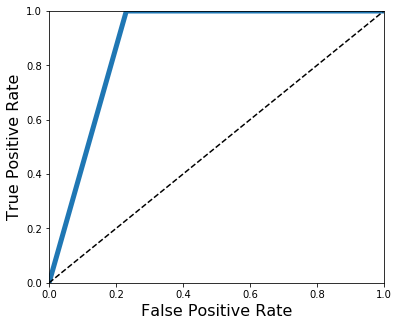

In [18]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr)

## <a name="1_3">1.3 Multiclass Classifier</a>
***
- #### [1.3.1 Preparing the classification data](#1_3_1)
- #### [1.3.2 Model selection and training](#1_3_2)
- #### [1.3.3 Measuring perfomance metrics (accuracy and confusion matrix)](#1_3_3)

### <a name="1_3_1">1.3.1 Preparing the classification data</a>
***
Here I am going to use the function discussed in the [first section](#1_1) for fetching and labelling the data for the new classification task. <br>
The data must be collected and grouped into three different classes:
- Overexposed illumniation | **Class 0**  
- Underexposed illumniation | **Class 1**
- Regular illumniation (non-uniform and uniform with F-stop equals to 0) | **Class 2**

<a href="#1_3" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [19]:
# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
overexp_images, overexp_org_sizes = get_images_by_keywords(grayscale_data, OVEREXPOSED_KEYWORDS)
overexp_labels = generate_labels_list(len(overexp_images), 0)

# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
underexp_images, underexp_org_sizes = get_images_by_keywords(grayscale_data, UNDEREXPOSED_KEYWORDS)
underexp_labels = generate_labels_list(len(underexp_images), 1)

# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
reg_images, reg_org_sizes = get_images_by_keywords(grayscale_data, REGULAR_KEYWORDS)
reg_labels = generate_labels_list(len(reg_images), 2)

# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
nonuni_images, nonuni_org_sizes = get_images_by_keywords(grayscale_data, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 2)

# defining length of the data
overexp_len = len(overexp_images)
underexp_len = len(underexp_images)
reg_len = len(reg_images) + len(nonuni_images)
print("Number of examples in over-exposed illumination pictures is {0}".format(overexp_len))
print("Number of examples in under-exposed illumination pictures is {0}".format(underexp_len))
print("Number of examples in regular illumination pictures is {0}".format(reg_len))

Number of examples in over-exposed illumination pictures is 60
Number of examples in under-exposed illumination pictures is 60
Number of examples in regular illumination pictures is 105


In [20]:
'''
    Constructing the input data (X) and the groundtruth (y)
'''
X = np.asarray(overexp_images + underexp_images + reg_images + nonuni_images)
y = np.asarray(overexp_labels + underexp_labels + reg_labels + nonuni_labels)

'''
    Shuffling the data with the same predefined permutation in section 1.1.2
'''
shuffled_X, shuffled_y = X[p], y[p]

'''
    Splitting the data the same split as in section 1.1.3
'''
test_size = len(shuffled_X) // 5
train_size = len(shuffled_X) - test_size
X_train, X_test, y_train, y_test = shuffled_X[:train_size], shuffled_X[train_size:], shuffled_y[:train_size], shuffled_y[train_size:]
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
print("Number of examples in the training set is {0}.".format(len(X_train)))
print("Number of examples in the testing set is {0}.".format(len(X_test)))

Number of examples in the training set is 180.
Number of examples in the testing set is 45.


### <a name="1_3_2">1.3.2 Model selection and training</a>
* * *
Here I've used the same Logistic Regression use in [section 1.2](#1_2) model as my classifier, and will compare two **multiclass** classifiers performances:
- **OneVsOne**.
- **OneVsRest**.

<a href="#1_3" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [21]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Defining the LogisticRegression classifier
multi_clf = LogisticRegressionCV(max_iter=40, tol=0.01, cv=skfold, solver='liblinear', random_state=42)
########################################
# OneVsOne training
ovo_clf = OneVsOneClassifier(multi_clf)
ovo_clf.fit(X_train, y_train)
########################################
# OneVsRest training
ovr_clf = OneVsRestClassifier(multi_clf)
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                   cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None, max_iter=40,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=42, refit=True,
                                                   scoring=None,
                                                   solver='liblinear', tol=0.01,
                                                   verbose=0),
                    n_jobs=None)

### <a name="1_3_3">1.3.3 Measuring perfomance metrics (accuracy and confusion matrix)</a>
* * *
Here we can observe that the **OneVsOne** classifier has perfected the training set by getting **100%** accuracy score, and no misclassifications in the confusion matrix.

***The output of the performance metrics on the testing set will be affected slightly by the permutation every time we run the jupyter notebook.*** <br>


But it doesn't seem to generalize its knowledge well to the testing set using the **OneVsOne** classifier, as the accuracy drops from **100%** in training set to **(82%-88%)**. <br>
This means that our models did not have enough training data and does not generalize well to the testing data **(unseen during training)**. The small size of the dataset contributes in that accuracy decay so much. <br>

By observing the confusion matrix for the testing set, we can conclude the following: <br>
- Some of the overexposed images are sometimes misclassified as regular images. That may be happening because of a presence of ambiguity between the difference in those images. But overexposed images are never misclassified as underexposed.
- Some of the underexposed images are sometimes as well misclassified as regular images. That may be happening because of the same reason as the overexposed images. But underexposed images are never misclassified as overexposed. 
- Some of regular images are sometimes classified as either overexposed or underexposed.

<a href="#1_3" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [22]:
y_train_pred = ovo_clf.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
ovo_train_acc = accuracy_score(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print('Training Accuracy is {0} '.format(ovo_train_acc))
print('Training Confusion matrix: \n {0}'.format(train_conf_matrix))

print('-------------------------------------------------')

y_test_pred = ovo_clf.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
ovo_test_acc = accuracy_score(y_test, y_test_pred)
print('Classifier scores on the testing set: ')
print('Testing Accuracy is {0} '.format(ovo_test_acc))
print('Confusion matrix: \n {0}'.format(test_conf_matrix))

Classifier scores on the whole training set: 
Training Accuracy is 1.0 
Training Confusion matrix: 
 [[43  0  0]
 [ 0 47  0]
 [ 0  0 90]]
-------------------------------------------------
Classifier scores on the testing set: 
Testing Accuracy is 0.8666666666666667 
Confusion matrix: 
 [[14  0  3]
 [ 0 12  1]
 [ 0  2 13]]


It seems that the **OneVsRest** classifier fits the training data perfectly as well. But let's inspect its performance on the testing data.

But it doesn't seem to generalize its knowledge to the testing set using the **OneVsRest** classifier, as the accuracy drops from **100%** to **84%-88%**, but it performs slightly better than the **OneVsOne** classifier. <br>
This means that our models lacks the training data and does not generalize well to the testing data. Also the dataset's small size contributes to the decrease in the accuracy. <br>

By observing the confusion matrix for the testing set, we can conclude the following: <br>
- Some of the overexposed images are sometimes misclassified as regular images. That may be happening because of a presence of ambiguity between the difference in those images. But overexposed images are never misclassified as underexposed.
- Some of the underexposed images are sometimes as well misclassified as regular images. That may be happening because of the same reason as the overexposed images. But underexposed images are never misclassified as overexposed. 
- Some of regular images are sometimes classified as either overexposed or underexposed.

These observations may be the same as for the **OneVsOne** classifier.

<a href="#1_3" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [23]:
y_train_pred = ovr_clf.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
ovo_train_acc = accuracy_score(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print('Training Accuracy is {0} '.format(ovo_train_acc))
print('Training Confusion matrix: \n {0}'.format(train_conf_matrix))

print('-------------------------------------------------')

y_test_pred = ovr_clf.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
ovo_test_acc = accuracy_score(y_test, y_test_pred)
print('Classifier scores on the testing set: ')
print('Testing Accuracy is {0} '.format(ovo_test_acc))
print('Confusion matrix: \n {0}'.format(test_conf_matrix))

Classifier scores on the whole training set: 
Training Accuracy is 1.0 
Training Confusion matrix: 
 [[43  0  0]
 [ 0 47  0]
 [ 0  0 90]]
-------------------------------------------------
Classifier scores on the testing set: 
Testing Accuracy is 0.8888888888888888 
Confusion matrix: 
 [[14  0  3]
 [ 0 13  0]
 [ 0  2 13]]


## <a name="1_4">1.4 Improved Classification of Colour Images (Bonus) | (100%) accuracy </a>
***
- #### [1.4.1 Testing the model from **1.3** with external images](#1_4_1)
- #### [1.4.2 Preparing the classification color data](#1_4_2)
- #### [1.4.3 Feature selection and extraction](#1_4_3)
- #### [1.4.4 Model selection and training](#1_4_4)
- #### [1.4.5 Measuring perfomance metrics (accuracy and confusion matrix)](#1_4_5)

### <a name="1_4_1">1.4.1 Testing the model from 1.3 with external images</a>
***
Here I am going to use the model trained from exercise [1.3](1_3) with images not in the main dataset. <br>
These images are randomly selected from the internet, and are not from the same distribution as the training or testing sets.

Source of the overexposed image: https://photo.stackexchange.com/questions/67848/why-are-all-my-photos-overexposed <br>
Source of the underexposed image: https://www.flickr.com/photos/32451477@N02/7374864048 <br>
Source of regular image: https://www.rte.ie/news/2015/1126/749334-alcohol-ads/ <br>

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


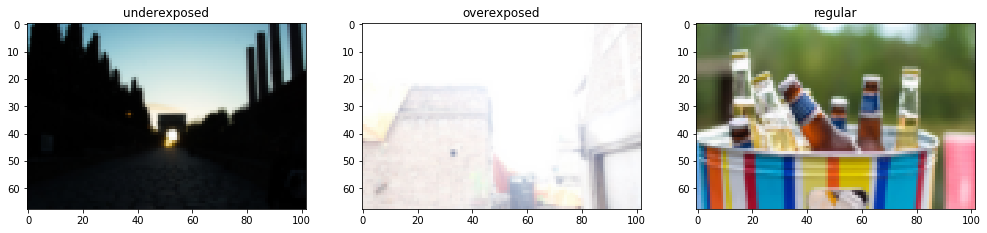

In [24]:
# Reading the data
external_data_filenames = get_files_within_dir('test_images', '.jpg')
external_data = read_images_from_files(external_data_filenames, 1., rgb=True, flatten=False)
external_images = []

# Resizing the data
for image, _, _ in external_data:
    image = skimage.transform.resize(image, (68, 102))
    external_images.append(image)
    
# Defining each image class
overexp_image = external_images[0]
reg_image = external_images[1]
underexp_image = external_images[2]

# Plotting them for visualization
fig = plt.figure(figsize=(17, 17))
fig.add_subplot(1, 3, 1)
plot_image(underexp_image, title="underexposed")
fig.add_subplot(1, 3, 2)
plot_image(overexp_image, title="overexposed")
fig.add_subplot(1, 3, 3)
plot_image(reg_image, title="regular")

Here I am going to use the **OneVsOne** trained in [section 1.3](1_3_2) classifier to test these random images.

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [26]:
for i, image, y_expected, label in [(0, overexp_image, [0], "overexposed"),
                                    (1, underexp_image, [1], "underexposed"), 
                                    (2, reg_image, [2], "regular")]:
    y_pred = ovo_clf.predict([skimage.color.rgb2gray(image).flatten()])
    if (y_expected == y_pred):
        print("The OvO classifier classified the {0} image right!".format(label))
    else:
        print("The OvO classifier made a mistake when classifying the {0} image!".format(label))
        print("Expected {0} and got {1}".format(y_expected, y_pred))
    if i != 2:
        print('-------------------------------------------------------------------')

The OvO classifier classified the overexposed image right!
-------------------------------------------------------------------
The OvO classifier classified the underexposed image right!
-------------------------------------------------------------------
The OvO classifier made a mistake when classifying the regular image!
Expected [2] and got [0]


This misclassification is expected as the testing images are not from the same distribution as the dataset. <br> 
As the training dataset is very small to make the classifier generalize very well on all differenet illumination classes. <br> 
Also in the confusion matrix, always the classifier seems to classify the 3rd class in a wrong way

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

### <a name="1_4_2">1.4.2 Preparing the classification color data</a>
***
Here I am going to use the function discussed in the [first section 1.1](#1_1) for fetching and labelling the data for the new classification task using color images. <br>
The data must be collected and grouped into three different classes:
- Overexposed illumniation | **Class 0**  
- Underexposed illumniation | **Class 1**
- Rgular illumniation (non-uniform and uniform with F-score equals to 0) | **Class 2**

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [27]:
color_images = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=True, flatten=False)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [28]:
# fetching overexposed illumination images by searching for the "plus" keyword in the images' filenames 
overexp_images, overexp_org_sizes = get_images_by_keywords(color_images, OVEREXPOSED_KEYWORDS)
overexp_labels = generate_labels_list(len(overexp_images), 0)

# fetching underexposed illumination images by searching for the "minus" keyword in the images' filenames 
underexp_images, underexp_org_sizes = get_images_by_keywords(color_images, UNDEREXPOSED_KEYWORDS)
underexp_labels = generate_labels_list(len(underexp_images), 1)

# fetching regular illumination images by searching for the "uni" and "0" (that indicats the F-stop) keyword in the images' filenames 
reg_images, reg_org_sizes = get_images_by_keywords(color_images, REGULAR_KEYWORDS)
reg_labels = generate_labels_list(len(reg_images), 2)

# fetching non-uniform illumination images by searching for the "nonuni" keyword in the images' filenames 
nonuni_images, nonuni_org_sizes = get_images_by_keywords(color_images, NONUNI_KEYWORDS)
nonuni_labels = generate_labels_list(len(nonuni_images), 2)

# defining length of the data
overexp_len = len(overexp_images)
underexp_len = len(underexp_images)
reg_len = len(reg_images) + len(nonuni_images)
print("Number of examples in over-exposed illumination pictures is {0}".format(overexp_len))
print("Number of examples in under-exposed illumination pictures is {0}".format(underexp_len))
print("Number of examples in regular illumination pictures is {0}".format(reg_len))

Number of examples in over-exposed illumination pictures is 60
Number of examples in under-exposed illumination pictures is 60
Number of examples in regular illumination pictures is 105


### <a name="1_4_3">1.4.3 Feature selection and extraction</a>
***
By considering the **classical computer vision pipeline**, we can conclude that we will need to extract representative features of the color images and train a classifier to these features, instead of infereing the image as a whole directly to the classifier during either training or testing. <br>
For this task, I have chosen the color histogram as a feature to extract from the image and train my classifier on that feature. <br>

#### Color Histogram Extraction:
- As I am going to use color images as my training data, I am going to extract color histograms from images, and treat these histograms as the features to be inferred into the multiclass classifier.
- Each image has 3 channels (RGB), so I am going to extract a histogram for each of these channels.
- The color histogram features are very useful in that task as they represent the distribution of color intensities accross all the image pixels.
- **skimage** reads the images and store each pixel value as a floating point value between 0 and 1.
- Using **numpy**'s **histogram** function, it takes the following:
    - The array that I need to compute its histogram.
    - The range of values inspected, which in our case will be from 0 to 1
    - The number of bins to represent the data, if we chose a big number of bins, it will result in more information about the pixel data, and the less the bins number, the less information we extract, I will be choosing 128 as the number of bins to represent my histogram
- Now to extract the features from the image I need to do the following:
    - Iterate over all the images
    - The image's shape should be (w, h, 3)
    - For each image, extract its channels, R channel, G channel and B channel separately
    - After extracting each channel's data, I will have three new arrays, each will have a shape of (w, h) only
    - For each of the three image channels, calculate its histogram using **np.histogram** function
    - Now I will have three different arrays, each of shape (bins) which is already specified by 128
    - Now I will stack these arrays after each other, so I will get a new arary of shape (bins * 3) which is in our case (128 * 3) -> (384)
    - Save that array as the image's extracted color histogram data
- Now we have to process all the image in the training set that way for training
- For the testing phase (inference), we will need to transform each image to its histogram equivalent as well before giving it as an input to the trained model
    

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [29]:
def extract_rgb_image_hist(images, bins=512):
    '''
        This function takes a list of images and returns a list of the images' equivalent extracted histogram data
        
        params: 
            List[np.ndarray] -> (image.shape == (w, h, 3))
        return:
            List[np.ndarray] -> (histogram.shape == (bins * 3))
    '''
    histograms = []
    for image in images:
        r_hist, _ = np.histogram(image[:, :, 0], bins=bins, range=(0., 1.))
        g_hist, _ = np.histogram(image[:, :, 1], bins=bins, range=(0., 1.))
        b_hist, _ = np.histogram(image[:, :, 2], bins=bins, range=(0., 1.))
        hist = np.array(r_hist.tolist() + g_hist.tolist() + b_hist.tolist())
        histograms.append(hist)
    return np.asarray(histograms)

In [30]:
'''
    Constructing the input data (X) and the groundtruth data (y) using the prede
'''
X_hist = extract_rgb_image_hist(np.asarray(overexp_images + underexp_images + reg_images + nonuni_images), bins=512)
y_hist = np.asarray(overexp_labels + underexp_labels + reg_labels + nonuni_labels)

'''
    Shuffling the data with the same predefined permutation in section 1.1.2
'''
shuffled_X, shuffled_y = X_hist[p], y_hist[p]

'''
    Splitting the data according to the process described in section 1.1.3
'''
test_size = len(shuffled_X) // 5
train_size = len(shuffled_X) - test_size
X_train, X_test, y_train, y_test = shuffled_X[:train_size], shuffled_X[train_size:], shuffled_y[:train_size], shuffled_y[train_size:]
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
print("Number of examples in the training set is {0}.".format(len(X_train)))
print("Number of examples in the testing set is {0}.".format(len(X_test)))

Number of examples in the training set is 180.
Number of examples in the testing set is 45.


### <a name="1_4_4">1.4.4 Model selection and training</a>
***
Here I am going to use both the **OneVsOne** and **OneVsRest** as classifier for the training process.

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [31]:
# OneVsOne
ovo_clf = OneVsOneClassifier(LogisticRegressionCV(max_iter=40, tol=0.01, cv=skfold, solver='liblinear', random_state=42))
ovo_clf.fit(X_train, y_train)
#############################
# OneVsRest
ovr_clf = OneVsRestClassifier(LogisticRegressionCV(max_iter=40, tol=0.01, cv=skfold, solver='liblinear', random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None,
                                                   cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1.0,
                                                   l1_ratios=None, max_iter=40,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=42, refit=True,
                                                   scoring=None,
                                                   solver='liblinear', tol=0.01,
                                                   verbose=0),
                    n_jobs=None)

### <a name="1_4_5">1.4.5 Measuring performance metrics (accuracy and confusion matrix)</a>
***
As we can see the following blocks, the color histogram features extraction resulted in perfection **100%** in performance metrics either using the **OneVsOne** or the **OneVsRest** classifier. <br>
That means that the color histograms are very rich and descriptive features when it comes to classify exposure/contrast/brightness of images. <br>
It means also the the small size of the data did not affect the model's performance and generalization on the **unseen data** of the testing set.

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [32]:
from sklearn.metrics import classification_report

target_names = ["overexposed", "underexposed", "regular"]

y_train_pred = ovo_clf.predict(X_train)
ovo_train_conf_mat = confusion_matrix(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_train_pred)))
print('Confusion matrix: \n {0}'.format(ovo_train_conf_mat))
print('------------------------------------------------------')

print("Classification Report for training set:")
print(classification_report(y_train, y_train_pred, target_names=target_names))

print('#######################################################')

y_test_pred = ovo_clf.predict(X_test)
ovo_test_conf_mat = confusion_matrix(y_test, y_test_pred)
print('Classifier scores on the testing set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_test_pred)))
print('Confusion matrix: \n {0}'.format(ovo_test_conf_mat))

print('------------------------------------------------------')

print("Classification Report for Testing set:")
print(classification_report(y_train, y_train_pred, target_names=target_names))

Classifier scores on the whole training set: 
Accuracy is 1.0 
Confusion matrix: 
 [[43  0  0]
 [ 0 47  0]
 [ 0  0 90]]
------------------------------------------------------
Classification Report for training set:
              precision    recall  f1-score   support

 overexposed       1.00      1.00      1.00        43
underexposed       1.00      1.00      1.00        47
     regular       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

#######################################################
Classifier scores on the testing set: 
Accuracy is 1.0 
Confusion matrix: 
 [[17  0  0]
 [ 0 13  0]
 [ 0  0 15]]
------------------------------------------------------
Classification Report for Testing set:
              precision    recall  f1-score   support

 overexposed       1.00      1.00      1.00        43
underexposed       1.00      1.0

In [33]:
y_train_pred = ovr_clf.predict(X_train)
ovo_train_conf_mat = confusion_matrix(y_train, y_train_pred)
print('Classifier scores on the whole training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_train_pred)))
print('Confusion matrix: \n {0}'.format(ovo_train_conf_mat))
print('------------------------------------------------------')

print("Classification Report for training set:")
print(classification_report(y_train, y_train_pred, target_names=target_names))

print('#######################################################')

y_test_pred = ovr_clf.predict(X_test)
ovo_test_conf_mat = confusion_matrix(y_test, y_test_pred)
print('Classifier scores on the testing set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_test_pred)))
print('Confusion matrix: \n {0}'.format(ovo_test_conf_mat))

print('------------------------------------------------------')

print("Classification Report for Testing set:")
print(classification_report(y_train, y_train_pred, target_names=target_names))

Classifier scores on the whole training set: 
Accuracy is 1.0 
Confusion matrix: 
 [[43  0  0]
 [ 0 47  0]
 [ 0  0 90]]
------------------------------------------------------
Classification Report for training set:
              precision    recall  f1-score   support

 overexposed       1.00      1.00      1.00        43
underexposed       1.00      1.00      1.00        47
     regular       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

#######################################################
Classifier scores on the testing set: 
Accuracy is 1.0 
Confusion matrix: 
 [[17  0  0]
 [ 0 13  0]
 [ 0  0 15]]
------------------------------------------------------
Classification Report for Testing set:
              precision    recall  f1-score   support

 overexposed       1.00      1.00      1.00        43
underexposed       1.00      1.0

But here the training and testing sets are from the same distribution, now let's try to infer some random image from outside of that distribution to one of these models (trained on color histograms), and see how the model performs on that.

<a href="#1_4" style="float: right">Return to beggining of section</a>
<br>
<a href="#head" style="float: right">Return to table of contents</a>

In [39]:
img = extract_rgb_image_hist([overexp_image, underexp_image, reg_image], 512)

for i, image, y_expected, label in [(0, np.array(img[0]), [0], "overexposed"),
                                    (1, np.array(img[1]), [1], "underexposed"), 
                                    (2, np.array(img[2]), [2], "regular")]:
    y_pred = ovo_clf.predict([image])
    if (y_expected == y_pred):
        print("The OvO classifier classified the {0} image right!".format(label))
    else:
        print("The OvO classifier made a mistake when classifying the {0} image!".format(label))
        print("Expected {0} and got {1}".format(y_expected, y_pred))
    if i != 2:
        print('-------------------------------------------------------------------')

The OvO classifier classified the overexposed image right!
-------------------------------------------------------------------
The OvO classifier made a mistake when classifying the underexposed image!
Expected [1] and got [2]
-------------------------------------------------------------------
The OvO classifier classified the regular image right!


## <a name="conc">Conclusion</a>
***
- Using the image grayscale pixels directly to train a binary classifier gave us good results, but that reflects how the problem is easy to separate only two classes using only grayscale pixel values.
- When trying to classify 3 different classes, its harder for a multi class classifier to separate these three classes using only grayscale images' pixel values.
- Considering the classical computer vision pipeline, and trying to carefully extract features from images and train the model on them instead of directly infering the pixels shows a huge improvments in the multi class classifier performance **(100% on both training and testing sets)**

<a href="#head" style="float: right">Return to table of contents</a>